In [1]:
import numpy as np
import xarray as xr
import cmocean

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cartopy.crs as ccrs

from mask_regions import mask_inland_seas, mask_poles
from make_cartopy_maps import add_global_map_subplot, add_regional_map_subplot, get_discrete_cmap
from analysis import compute_future_change, wrap_argmonth_diff, compute_sign_agreement
from analysis_io import open_zos_ibe_monmeans, open_aslc_range, open_aslc_amax

In [2]:
import gcsfs
fs = gcsfs.GCSFileSystem() #list stores, stripp zarr from filename, load 

def open_anmax(path,chunks):
    fns = ['gs://'+k for k in fs.ls(path) if 'DS_Store' not in k]
    return xr.open_mfdataset(fns,combine='nested',coords='minimal',compat='override',concat_dim = 'source_id',chunks=chunks,engine='zarr')

Load anmax:

In [3]:
ssp='ssp585'
exclude_models = ['INM-CM5-0','INM-CM4-8','GISS-E2-1-G','MIROC-ES2L'] #poorly performing models

#open historical ASLC range and amax, excluding poorly performing models:
anmax = open_anmax('gs://leap-persistent/timh37/CMIP6/zos_ibe_1x1_annual_maxima',{'lat':500,'lon':500,'period':1,'member_id':50,'experiment_id':4}).sel(experiment_id=ssp).drop_sel(source_id=exclude_models)#.load()
anmax_tgs = open_anmax('gs://leap-persistent/timh37/CMIP6/zos_ibe_psmsl_annual_maxima',{'id':1000,'period':2,'member_id':200}).sel(experiment_id=ssp).drop_sel(source_id=exclude_models).load()

#mask out where less than 10 models are ocean
more_than_10_models = np.isfinite(anmax.zos_ibe).any(dim='member_id').sum(dim='source_id')>=10 #mask for gridded fields where less than 10 models have data

#3): mask out poles and inland seas
anmax = mask_poles( mask_inland_seas( anmax.where(more_than_10_models) ) )
anmax_tgs = mask_poles( mask_inland_seas( anmax_tgs ) )

In [4]:
psmsl = xr.open_dataset('../month_means_1993_2022_psmsl.nc')
psmsl = mask_poles(mask_inland_seas(psmsl))
psmsl = psmsl.where(np.isfinite(psmsl.isel(month=0,drop=True)),drop=True)

In [5]:
#select cmip6 data only where observations are not masked out
anmax_tgs = anmax_tgs.sel({'id':psmsl.id}) 

Compute future ASLC changes

In [6]:
#compute change anomalies
anmax_change = 100*(compute_future_change(anmax)).load()
anmax_change_tgs = 100*(compute_future_change(anmax_tgs)).load()

Load annual mean:

In [7]:
exclude_models = ['INM-CM5-0','INM-CM4-8','GISS-E2-1-G','MIROC-ES2L'] #poorly performing models

datasets = []
for s,ssp in enumerate(['ssp585']):
    datasets_ssp = []
    
    fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/seasonal_slc/merged/') if '1x1' in k and ssp in k]
    datasets_ssp = xr.open_mfdataset(fns,combine='nested',coords='minimal',compat='override',concat_dim='season',engine='zarr')
    datasets_ssp['season']=[k.split('/')[-1].split('_')[0] for k in fns]
    datasets.append(datasets_ssp)
seasonal_slc = xr.concat(datasets,dim='experiment_id').drop_sel(source_id=exclude_models).load()

datasets = []
for s,ssp in enumerate(['ssp585']):
    datasets_ssp = []
    
    fns = ['gs://'+k for k in fs.ls('gs://leap-persistent/timh37/CMIP6/seasonal_slc/merged/') if 'psmsl' in k and ssp in k]
    datasets_ssp = xr.open_mfdataset(fns,combine='nested',coords='minimal',compat='override',concat_dim='season',engine='zarr')
    datasets_ssp['season']=[k.split('/')[-1].split('_')[0] for k in fns]
    datasets.append(datasets_ssp)
seasonal_slc_tgs = xr.concat(datasets,dim='experiment_id').drop_sel(source_id=exclude_models).load()

#mask out some regions
seasonal_slc = mask_poles(mask_inland_seas(seasonal_slc)) #mask out some regions
seasonal_slc_tgs = mask_poles(mask_inland_seas(seasonal_slc_tgs))

#mask out gridded fields where less than 10 models have data
more_than_10_models = np.isfinite(seasonal_slc.zos_ibe.isel(season=0,drop=True)).sum(dim='source_id')>=10
seasonal_slc = seasonal_slc.where(more_than_10_models) #mask out where less than 10 models are ocean

seasonal_slc_tgs = seasonal_slc_tgs.sel({'id':psmsl.id}) #select only where observations are not masked out

In [8]:
anmean_change = seasonal_slc.sel(season='annual').load()
anmean_change_tgs = seasonal_slc_tgs.sel(season='annual').load()

In [9]:
anmax_anom = anmax_change - anmean_change.sel(experiment_id=ssp)
anmax_anom_tgs = anmax_change_tgs - anmean_change_tgs.sel(experiment_id=ssp)

anmax_anom_memmean  = anmax_anom.mean(dim='member_id')
anmax_anom_memmean_tgs  = anmax_anom_tgs.mean(dim='member_id')

sign_agreement = compute_sign_agreement(anmax_anom_memmean,'source_id',2/3)
sign_agreement_tgs = compute_sign_agreement(anmax_anom_memmean_tgs,'source_id',2/3)

**Make plots:**

Plot global ASLC range & peakmonth changes:

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


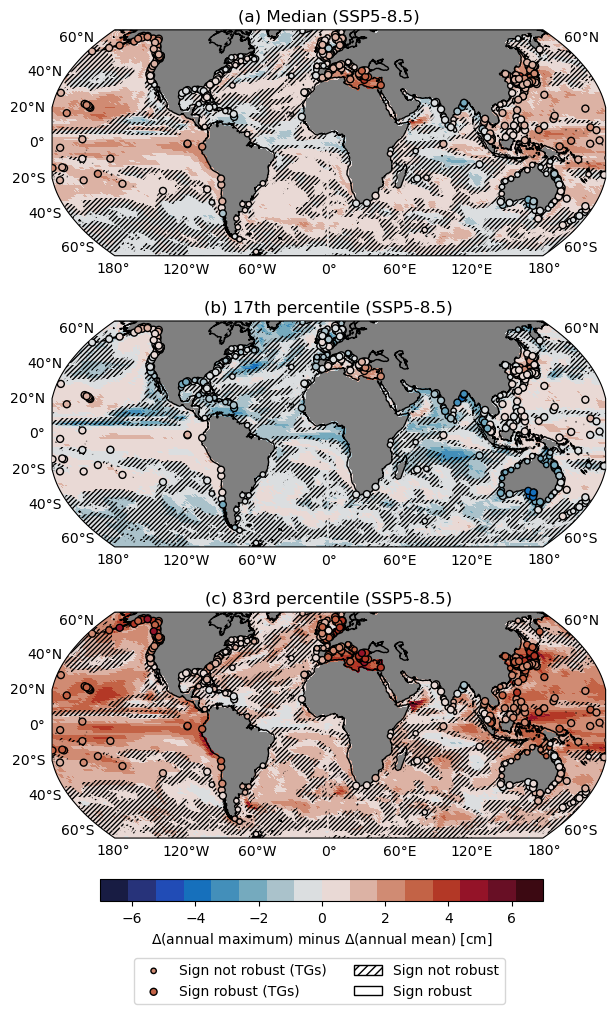

In [23]:
save_fig = 1

fig = plt.figure(figsize=(15,11))
gs1 = fig.add_gridspec(3,2,hspace=.1,wspace=.1)#,bottom=.56) #for the first plots

var = 'zos_ibe'

vmin_range = -7
vmax_range = 7
vmin_amax = -2.5
vmax_amax = 2.5

#RANGE
#median
balance_discrete = get_discrete_cmap(cmocean.cm.balance, 16)

fig,ax = add_global_map_subplot(fig,anmax_anom_memmean[var].median(dim='source_id'),
                                 gs1[0,0],vmin_range,vmax_range,balance_discrete,'(a) Median (SSP5-8.5)',sign_agreement[var]==False,False,'Annual maximum change anomaly [cm]')
ax.set_facecolor("gray")

s1=ax.scatter(anmax_anom_tgs.lon[sign_agreement_tgs[var]==False],anmax_anom_tgs.lat[sign_agreement_tgs[var]==False],
              c=anmax_anom_memmean_tgs[var].median(dim='source_id')[sign_agreement_tgs[var]==False],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
s2=ax.scatter(anmax_anom_tgs.lon[sign_agreement_tgs[var]==True],anmax_anom_tgs.lat[sign_agreement_tgs[var]==True],
              c=anmax_anom_memmean_tgs[var].median(dim='source_id')[sign_agreement_tgs[var]==True],
               vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')

for q,quant in enumerate([.17,.83]):

    fig,ax = add_global_map_subplot(fig,anmax_anom_memmean[var].quantile(quant,dim='source_id'),
                                     gs1[1+q,0],vmin_range,vmax_range,balance_discrete,['(b) 17th percentile (SSP5-8.5)','(c) 83rd percentile (SSP5-8.5)'][q],sign_agreement[var]==False,[False,'below'][q],r'$\Delta$(annual maximum) minus $\Delta$(annual mean) [cm]')
    ax.set_facecolor("gray")
    
    s1=ax.scatter(anmax_anom_tgs.lon[sign_agreement_tgs[var]==False],anmax_anom_tgs.lat[sign_agreement_tgs[var]==False],
                  c=anmax_anom_memmean_tgs[var].quantile(quant,dim='source_id')[sign_agreement_tgs[var]==False],
                   vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete,edgecolor='black',s=15,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign not robust (TGs)')
    s2=ax.scatter(anmax_anom_tgs.lon[sign_agreement_tgs[var]==True],anmax_anom_tgs.lat[sign_agreement_tgs[var]==True],
                  c=anmax_anom_memmean_tgs[var].quantile(quant,dim='source_id')[sign_agreement_tgs[var]==True],
                   vmin=vmin_range,vmax=vmax_range,cmap=balance_discrete,edgecolor='black',s=25,marker='o',transform=ccrs.PlateCarree(),zorder=5,label='Sign robust (TGs)')


import matplotlib.patches as mpatches
hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=r'////',label='Sign not robust')
no_hatching = mpatches.Patch( facecolor='white',edgecolor='black',hatch=None,label='Sign robust')
ax.legend(handles = [s1,s2,hatching,no_hatching],bbox_to_anchor=(.53, -1, 0.3, 0.5),ncols=2)


if save_fig:
    fig.savefig('figures/anmax_change_anomaly_'+var+'_'+ssp+'_global.jpg',format='jpg',dpi=300, bbox_inches='tight')            